#### Run evaluation on existing small unsloth models

In [14]:
import os
from dotenv import load_dotenv

load_dotenv()

hf_token = os.getenv("HF_TOKEN", "")
os.environ["HF_TOKEN"] = hf_token


In [13]:
from lm_eval import evaluator
import torch

res = evaluator.simple_evaluate(
    batch_size = 64,
    model = "hf",
    model_args = "pretrained=google/gemma-3-1b-it",
    #model_args = "pretrained=mistralai/Mistral-7B-Instruct-v0.3,dtype=float16",
    apply_chat_template=True,
    #tasks=["_ro_winogrande","_ro_belebele","ro_wiki","_ro_mmlu"], 
    tasks=["arc_challenge","winogrande"],
    device = 'auto',
    #dtype = torch.float16,
    limit = 1,
    #verbosity = "DEBUG",
    #log_samples=True,       # Ensure this is True
    #write_out=True,        # Save model inputs/outputs to disk for inspection
    num_fewshot = 5
)

2025-11-08:18:51:58,293 INFO     [evaluator.py:158] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2025-11-08:18:51:58,293 INFO     [evaluator.py:195] Initializing hf model, with arguments: {'pretrained': 'google/gemma-3-1b-it'}
2025-11-08:18:51:58,294 INFO     [huggingface.py:178] Device not specified
2025-11-08:18:51:58,294 INFO     [huggingface.py:179] Cuda Available? False
2025-11-08:18:52:00,061 INFO     [__init__.py:491] `group` and `group_alias` keys in tasks' configs will no longer be used in the next release of lm-eval. `tag` will be used to allow to call a collection of tasks just like `group`. `group` will be removed in order to not cause confusion with the new ConfigurableGroup which will be the offical way to create groups with addition of group-wide configuations.
2025-11-08:18:52:01,984 INFO     [__init__.py:512] The tag xnli is already registered as a group, this tag will not be registered. This may affect tasks you want to cal

#### Visualize Results

In [ ]:
import os
import json
import pandas as pd
from pathlib import Path


def extract_metrics_from_results(results_dir='results'):
    """
    Enumerate all JSON files in results directory and extract metrics for specified tasks.
    
    Args:
        results_dir: Path to the results directory
    
    Returns:
        pandas.DataFrame with extracted metrics in long format
    """
    tasks_to_run = [
        "_ro_winogrande", 
        "_ro_belebele", 
        "_ro_arc_challenge", 
        "arc_challenge", 
        "winogrande", 
        "ro_wiki",
        
    ]
    
    # Store all extracted data
    all_data = []
    
    # Get all JSON files in the results directory
    results_path = Path(results_dir)
    
    if not results_path.exists():
        print(f"Directory '{results_dir}' does not exist!")
        return pd.DataFrame()
    
    json_files = list(results_path.glob('*.json'))
    
    if not json_files:
        print(f"No JSON files found in '{results_dir}'")
        return pd.DataFrame()
    
    print(f"Found {len(json_files)} JSON file(s) in '{results_dir}'\n")
    
    # Process each JSON file
    json_files = [jfile for jfile in json_files if jfile.name!="eval_results.json"]
    for json_file in json_files:
        print(f"Processing: {json_file.name}")
        
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            # Check for each task
            for task in tasks_to_run:
                # The task name is the top-level key
                if task in data:
                    print(f"  ✓ Found task: {task}")
                    
                    task_data = data[task]
                    
                    # Try to extract results - handle two possible structures
                    task_results = None
                    task_config = None
                    
                    # Structure 1: task -> results -> task -> metrics
                    if 'results' in task_data and task in task_data['results']:
                        task_results = task_data['results'][task]
                        task_config = task_data.get('configs', {}).get(task, {})
                    
                    # Structure 2: task -> results -> metrics (for ro_wiki and similar)
                    elif 'results' in task_data and isinstance(task_data['results'], dict):
                        # Get the first (and likely only) key in results
                        result_keys = list(task_data['results'].keys())
                        if result_keys:
                            first_key = result_keys[0]
                            task_results = task_data['results'][first_key]
                            task_config = task_data.get('configs', {}).get(first_key, {})
                    
                    if task_results:
                        num_fewshot = task_config.get('num_fewshot', 'N/A') if task_config else 'N/A'
                        output_type = task_config.get('output_type', 'N/A') if task_config else 'N/A'
                        
                        # Extract metrics and create separate rows for each metric
                        for key, value in task_results.items():
                            if key == 'alias':  # Skip alias field
                                continue
                            
                            # Parse metric name and type (e.g., "acc_norm,none" -> "acc_norm")
                            if ',none' in key:
                                metric_name = key.replace(',none', '')
                                
                                # Check if this is a main metric or stderr
                                if '_stderr' in metric_name:
                                    # This is a stderr metric, skip it for now
                                    # We'll match it with its main metric
                                    continue
                                else:
                                    # This is a main metric
                                    metric_type = metric_name
                                    metric_score = value
                                    
                                    # Look for corresponding stderr
                                    stderr_key = f"{metric_name}_stderr,none"
                                    metric_stderr = task_results.get(stderr_key, None)
                                    
                                    # Create record
                                    record = {
                                        'task_name': task,
                                        'metric_type': metric_type,
                                        'metric_score': metric_score,
                                        'metric_stderr': metric_stderr,
                                        'num_fewshot': num_fewshot,
                                        'output_type': output_type,
                                        'file': json_file.name,
                                    }
                                    
                                    all_data.append(record)
                    else:
                        print(f"  ⚠ Task '{task}' found but missing 'results' structure")
                else:
                    print(f"  ✗ Task '{task}' not present")
        
        except json.JSONDecodeError as e:
            print(f"  ✗ Error reading {json_file.name}: {e}")
        except Exception as e:
            print(f"  ✗ Unexpected error with {json_file.name}: {e}")
        
        print()  # Empty line between files
    
    # Create DataFrame
    if all_data:
        df = pd.DataFrame(all_data)
        
        # Reorder columns
        df = df[['task_name', 'metric_type', 'metric_score', 'metric_stderr', 
                 'num_fewshot', 'output_type', 'file']]
        
        return df
    else:
        print("No data extracted from any files")
        return pd.DataFrame()

In [ ]:
res_df

In [51]:
dfs = []
models = ['google_gemma-3-1b-it','google_gemma-3-1b-pt','meta-llama_Llama-3.2-1B','meta-llama_Llama-3.2-1B-Instruct','Qwen_Qwen2.5-1.5B']
for model_name in models:
    df = extract_metrics_from_results(f'../eval_results/{model_name}/results')
    df['model'] = model_name

    dfs.append(df)

res_df = pd.concat(dfs,ignore_index=True)

res_df = res_df[~res_df['metric_type'].isin(['byte_perplexity','bits_per_byte'])]
res_df = res_df[['model'] + [col for col in res_df.columns if col !="model"]]

Found 7 JSON file(s) in '../eval_results/google_gemma-3-1b-it/results'

Processing: ro_wiki.json
  ✗ Task '_ro_winogrande' not present
  ✗ Task '_ro_belebele' not present
  ✗ Task '_ro_arc_challenge' not present
  ✗ Task 'arc_challenge' not present
  ✗ Task 'winogrande' not present
  ✓ Found task: ro_wiki

Processing: winogrande.json
  ✗ Task '_ro_winogrande' not present
  ✗ Task '_ro_belebele' not present
  ✗ Task '_ro_arc_challenge' not present
  ✗ Task 'arc_challenge' not present
  ✓ Found task: winogrande
  ✗ Task 'ro_wiki' not present

Processing: arc_challenge.json
  ✗ Task '_ro_winogrande' not present
  ✗ Task '_ro_belebele' not present
  ✗ Task '_ro_arc_challenge' not present
  ✓ Found task: arc_challenge
  ✗ Task 'winogrande' not present
  ✗ Task 'ro_wiki' not present

Processing: _ro_arc_challenge.json
  ✗ Task '_ro_winogrande' not present
  ✗ Task '_ro_belebele' not present
  ✓ Found task: _ro_arc_challenge
  ✗ Task 'arc_challenge' not present
  ✗ Task 'winogrande' not prese

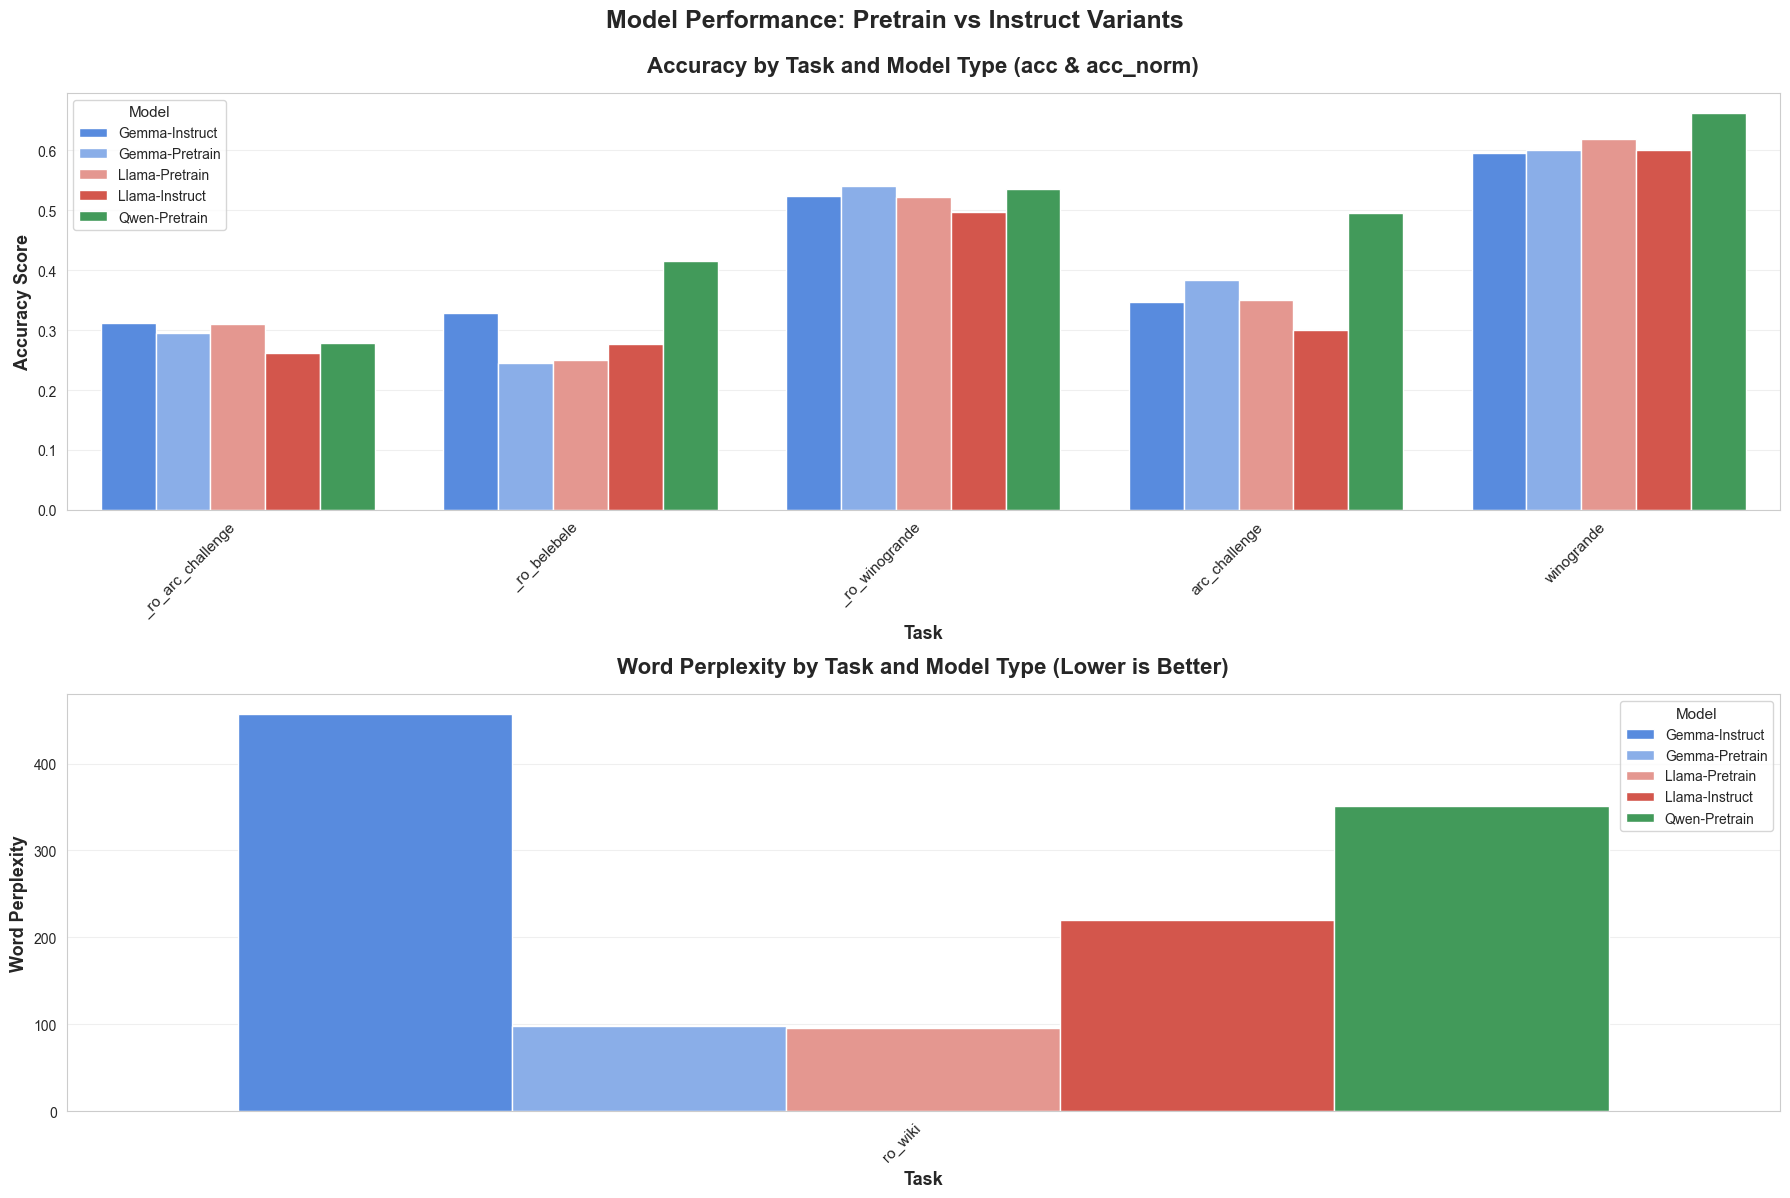


SUMMARY: Pretrain vs Instruct Performance

Metrics per task:
task_name
_ro_arc_challenge           [acc_norm]
_ro_belebele                [acc_norm]
_ro_winogrande                   [acc]
arc_challenge          [acc, acc_norm]
ro_wiki              [word_perplexity]
winogrande                       [acc]
Name: metric_type, dtype: object

ACCURACY METRICS (acc & acc_norm):
                           mean     std
model_type model_family                
Instruct   Gemma         0.4086  0.1197
           Llama         0.3731  0.1415
Pretrain   Gemma         0.4079  0.1382
           Llama         0.4003  0.1403
           Qwen          0.4808  0.1285

Per-task breakdown:
model_type         Instruct  Pretrain
task_name                            
_ro_arc_challenge    0.2865    0.2943
_ro_belebele         0.3022    0.3033
_ro_winogrande       0.5110    0.5327
arc_challenge        0.3238    0.4100
winogrande           0.5980    0.6277

WORD PERPLEXITY:
                             mean  std
m

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data with model grouping
res_df['model_type'] = res_df['model'].map({
    'google_gemma-3-1b-it': 'Instruct',
    'google_gemma-3-1b-pt': 'Pretrain',
    'meta-llama_Llama-3.2-1B': 'Pretrain',
    'meta-llama_Llama-3.2-1B-Instruct': 'Instruct',
    'Qwen_Qwen2.5-1.5B': 'Pretrain'
})

res_df['model_family'] = res_df['model'].map({
    'google_gemma-3-1b-it': 'Gemma',
    'google_gemma-3-1b-pt': 'Gemma',
    'meta-llama_Llama-3.2-1B': 'Llama',
    'meta-llama_Llama-3.2-1B-Instruct': 'Llama',
    'Qwen_Qwen2.5-1.5B': 'Qwen'
})

res_df['model_short'] = res_df['model_family'] + '-' + res_df['model_type']

# Filter for accuracy metrics (acc, acc_norm) and word_perplexity
filtered_df = res_df[res_df['metric_type'].isin(['acc', 'acc_norm', 'word_perplexity'])].copy()

# Separate accuracy metrics from perplexity
acc_df = filtered_df[filtered_df['metric_type'].isin(['acc', 'acc_norm'])].copy()
perp_df = filtered_df[filtered_df['metric_type'] == 'word_perplexity'].copy()

# Create figure with 2 rows
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Define color palette grouped by model family and type
palette = {
    'Gemma-Pretrain': '#7BAAF7',    # Light Blue
    'Gemma-Instruct': '#4285F4',    # Dark Blue
    'Llama-Pretrain': '#F28B82',    # Light Red
    'Llama-Instruct': '#EA4335',    # Dark Red
    'Qwen-Pretrain': '#34A853'      # Green
}

# Plot 1: Accuracy (combining acc and acc_norm)
if not acc_df.empty:
    # Get all unique tasks for accuracy
    tasks = sorted(acc_df['task_name'].unique())
    
    sns.barplot(
        data=acc_df,
        x='task_name',
        y='metric_score',
        hue='model_short',
        palette=palette,
        ax=axes[0],
        errorbar=None,
        order=tasks
    )
    
    axes[0].set_title('Accuracy by Task and Model Type (acc & acc_norm)', 
                      size=16, weight='bold', pad=15)
    axes[0].set_xlabel('Task', fontsize=13, weight='bold')
    axes[0].set_ylabel('Accuracy Score', fontsize=13, weight='bold')
    axes[0].legend(title='Model', fontsize=10, title_fontsize=11, loc='best')
    axes[0].tick_params(axis='x', rotation=45, labelsize=11)
    for label in axes[0].get_xticklabels():
        label.set_ha('right')
    axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Word Perplexity
if not perp_df.empty:
    # Get all unique tasks for word_perplexity
    tasks = sorted(perp_df['task_name'].unique())
    
    sns.barplot(
        data=perp_df,
        x='task_name',
        y='metric_score',
        hue='model_short',
        palette=palette,
        ax=axes[1],
        errorbar=None,
        order=tasks
    )
    
    axes[1].set_title('Word Perplexity by Task and Model Type (Lower is Better)', 
                      size=16, weight='bold', pad=15)
    axes[1].set_xlabel('Task', fontsize=13, weight='bold')
    axes[1].set_ylabel('Word Perplexity', fontsize=13, weight='bold')
    axes[1].legend(title='Model', fontsize=10, title_fontsize=11, loc='best')
    axes[1].tick_params(axis='x', rotation=45, labelsize=11)
    for label in axes[1].get_xticklabels():
        label.set_ha('right')
    axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('Model Performance: Pretrain vs Instruct Variants', 
             fontsize=18, weight='bold', y=0.995)
plt.tight_layout()
plt.savefig('model_comparison_pt_vs_it.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("SUMMARY: Pretrain vs Instruct Performance")
print("="*70)

# Check what metrics exist for each task
print("\nMetrics per task:")
print(res_df.groupby('task_name')['metric_type'].unique())

# Summary for accuracy metrics
print("\n" + "="*70)
print("ACCURACY METRICS (acc & acc_norm):")
print("="*70)
if not acc_df.empty:
    # Group by model type and family
    summary = acc_df.groupby(['model_type', 'model_family'])['metric_score'].agg(['mean', 'std']).round(4)
    print(summary)
    
    # Also show per-task breakdown
    print("\nPer-task breakdown:")
    task_summary = acc_df.pivot_table(
        index='task_name',
        columns='model_type',
        values='metric_score',
        aggfunc='mean'
    ).round(4)
    print(task_summary)

# Summary for perplexity
print("\n" + "="*70)
print("WORD PERPLEXITY:")
print("="*70)
if not perp_df.empty:
    summary = perp_df.groupby(['model_type', 'model_family'])['metric_score'].agg(['mean', 'std']).round(4)
    print(summary)
    
    # Also show per-task breakdown
    print("\nPer-task breakdown:")
    task_summary = perp_df.pivot_table(
        index='task_name',
        columns='model_type',
        values='metric_score',
        aggfunc='mean'
    ).round(4)
    print(task_summary)